# Data Analysis
Before we proceed to building our model we have to explore and prepare the data.

Notebook overview:
- data loading
- visualization
- adding indicators
- exporting to .csv files
- normalization methods overview

In [1]:
import pandas as pd
import numpy as np
from utils import *

# Data Loading
To make the problem more universal to work with I will keep only 4 columns: Open, High, Low, Close.

## NASDAQ

In [2]:
data_dir = '../data/'
nasdaq = pd.read_csv(data_dir + 'NASDAQ/Composite-2015-2019-D1.csv')

In [3]:
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,4726.810059,1435150000
1,2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,4652.569824,1794470000
2,2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,4592.740234,2167320000
3,2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,4650.470215,1957950000
4,2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,4736.189941,2105450000


In [4]:
nasdaq.drop(['Adj Close', 'Volume'], axis=1, inplace=True)

In [5]:
nasdaq = nasdaq.set_index('Date')

In [6]:
nasdaq.index = pd.to_datetime(nasdaq.index)

In [7]:
nasdaq.head()

,Open,High,Low,Close
Date,,,,
2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059
2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824
2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234
2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215
2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941


## EURUSD

In [8]:
eurusd = load_file_split(data_dir + 'EURUSD/')

In [9]:
eurusd.tail()

,Date,Time,Open,High,Low,Close,Ticks
1458710,2019.11.29,16:54,1.10176,1.10202,1.10174,1.10200,0
1458711,2019.11.29,16:55,1.10199,1.10218,1.10149,1.10149,0
1458712,2019.11.29,16:56,1.10173,1.10174,1.10173,1.10173,0
1458713,2019.11.29,16:57,1.10173,1.10174,1.10173,1.10173,0
1458714,2019.11.29,16:58,1.10157,1.10174,1.10157,1.10158,0


In [10]:
eurusd.drop(['Ticks'], axis=1, inplace=True)

### Change timeframe
Because current size of the EURUSD dataset is large, it is best to change the timeframe to a longer one: 1H (one candle per hour).

> This operation may take some time

In [11]:
eurusd = change_timeframe(eurusd, 60*24)

In [12]:
len(eurusd), len(nasdaq)

(1013, 1259)

In [13]:
eurusd.loc[:,'Date'] = eurusd.loc[:,'Date'] + ' ' + eurusd.loc[:,'Time']
eurusd.drop(['Time'], inplace=True, axis=1)
eurusd = eurusd.set_index('Date')

In [14]:
eurusd.index = pd.to_datetime(eurusd.index)

In [15]:
eurusd.head()

,Open,High,Low,Close
Date,,,,
2016-01-04 17:03:00,1.08701,1.09464,1.07811,1.08310
2016-01-05 17:03:00,1.08309,1.08388,1.07106,1.07461
2016-01-06 17:03:00,1.07458,1.07994,1.07185,1.07807
2016-01-07 17:03:00,1.07805,1.09401,1.07710,1.09307
2016-01-10 17:03:00,1.09298,1.09333,1.08030,1.09184


# Visualization & exploration
To easily plot financial history data `mplfinance` module will be needed.

In [17]:
!pip install mplfinance

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

%matplotlib inline

# Full market data
What we can see is that there can be large gaps in our time frame (especially in the EURUSD data). This happens because market is closed on weekends and holidays.

I will add a `Gap` column, which can improve accuracy.

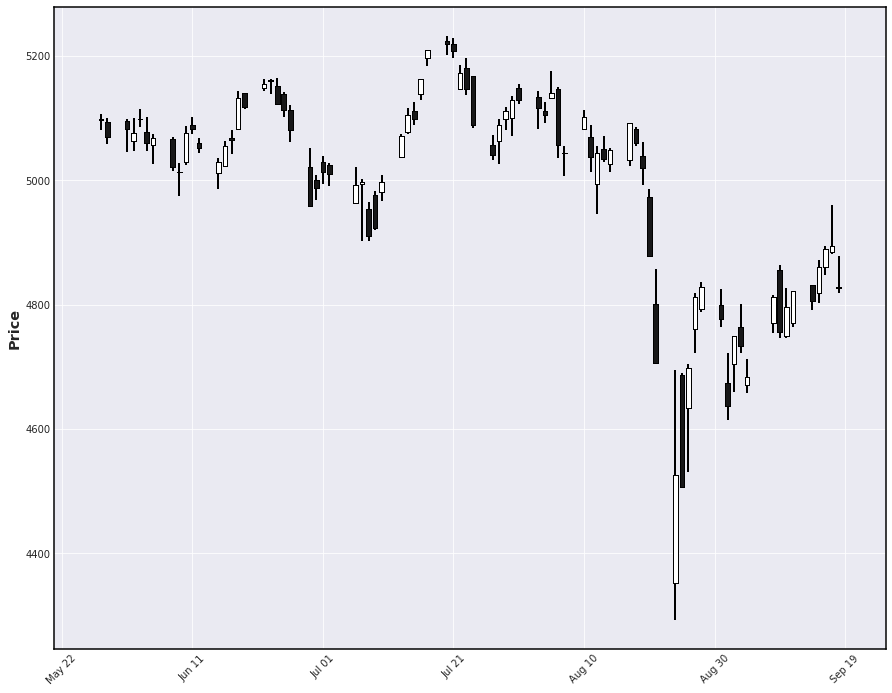

In [104]:
mpf.plot(nasdaq.iloc[100:180], type='candle', no_xgaps=False, figscale=1.5)

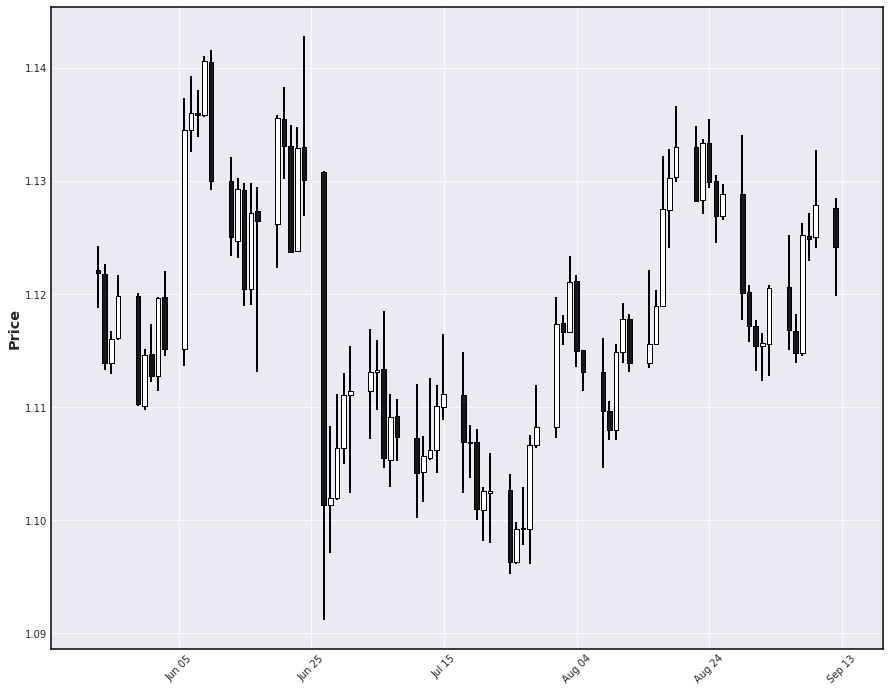

In [105]:
mpf.plot(eurusd.iloc[100:180], type='candle', no_xgaps=False, figscale=1.5)

## Values distribution
Normal distribution is a favourite for ML models. What we can see is that Volume is already well distributed.
EURUSD looks quite decent, but it still has abnormally infrequent values.
NASDAQ on the other hand definetely needs some transformation, since it is nowhere close to normal distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93bb4d0be0>,
      dtype=object)

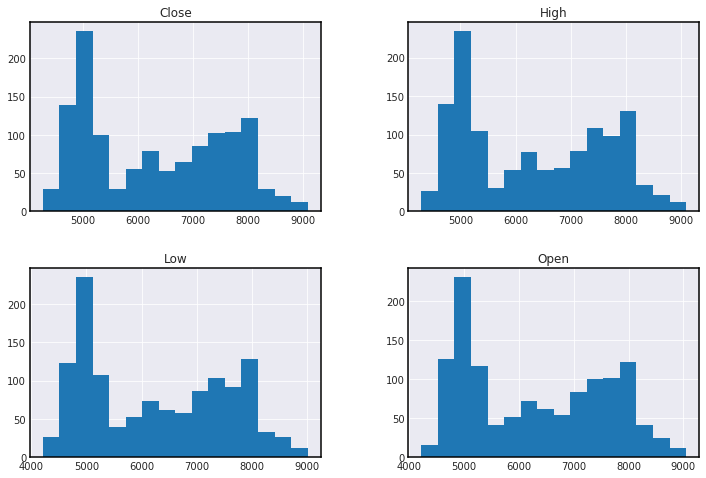

In [19]:
nasdaq.hist(figsize=(12,8), bins=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93bb2d4668>,
      dtype=object)

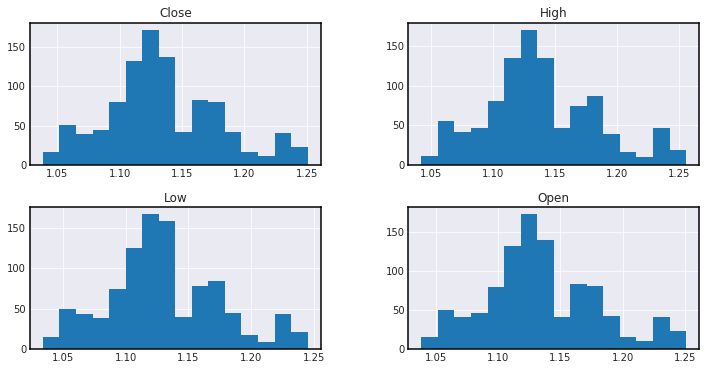

In [20]:
eurusd.hist(figsize=(12,6), bins=16)

# Indicators
Using this data, we can calculate any indicator we want.
I have chosen a few popular indicators and implemented them in the `indicators` module, which you can find in this project.

The same indicators should be applied on the input provided to deployed model.

> **Warning:** applying indicators can take a long time! They are iterating over the dataset which is very large.

In [21]:
import model.indicators as indicators
# Gap(timedelta=np.timedelta64(1,'h'))
# SMA(N=5)
# EMA(P=0.5)
# Momentum()
# RSI(period=14)

In [22]:
nasdaq = indicators.Gap(nasdaq, np.timedelta64(1,'D'))
nasdaq = indicators.EMA(nasdaq, P=0.03)
nasdaq = indicators.SMA(nasdaq, N=70)
nasdaq = indicators.Momentum(nasdaq)
nasdaq = indicators.RSI(nasdaq, period=14)

In [23]:
nasdaq.tail(10)

,Open,High,Low,Close,Gap,EMA,SMA,Momentum,RSI
Date,,,,,,,,,
2019-12-18,8834.650391,8848.759766,8820.419922,8827.740234,1.0,8408.000768,8309.070717,4.379882,64.285714
2019-12-19,8838.969727,8888.129883,8838.969727,8887.219727,1.0,8422.377337,8319.693290,59.479493,64.285714
2019-12-20,8911.839844,8931.910156,8901.870117,8924.959961,1.0,8437.454815,8329.943855,37.740234,71.428571
2019-12-23,8950.200195,8956.639648,8934.549805,8945.650391,3.0,8452.700683,8340.379429,20.690430,78.571429
2019-12-24,8955.009766,8957.120117,8934.360352,8952.879883,1.0,8467.706059,8351.364293,7.229492,85.714286
2019-12-26,8970.209961,9022.459961,8968.459961,9022.389648,2.0,8484.346566,8362.783433,69.509765,85.714286
2019-12-27,9049.469727,9052.000000,8987.320313,9006.620117,1.0,8500.014773,8374.731571,-15.769531,85.714286
2019-12-30,9004.450195,9006.360352,8909.190430,8945.990234,3.0,8513.394037,8386.577713,-60.629883,78.571429
2019-12-31,8918.740234,8975.360352,8912.769531,8972.599609,1.0,8527.170204,8397.479290,26.609375,78.571429


In [27]:
eurusd = indicators.Gap(eurusd, np.timedelta64(1,'D'))
eurusd = indicators.EMA(eurusd, P=0.03)
eurusd = indicators.SMA(eurusd, N=70)
eurusd = indicators.Momentum(eurusd)
eurusd = indicators.RSI(eurusd, period=14)

In [28]:
eurusd.tail(10)

,Open,High,Low,Close,Gap,EMA,SMA,Momentum,RSI
Date,,,,,,,,,
2019-11-18 16:52:00,1.10518,1.10899,1.10487,1.10717,3.002778,1.107302,1.105079,0.00197,50.000000
2019-11-19 16:56:00,1.10718,1.10839,1.10626,1.10779,1.002778,1.107316,1.104879,0.00062,50.000000
2019-11-20 16:57:00,1.10775,1.10813,1.10530,1.10718,1.000694,1.107312,1.104744,-0.00061,50.000000
2019-11-21 16:57:00,1.10716,1.10969,1.10522,1.10582,1.000000,1.107267,1.104656,-0.00136,42.857143
2019-11-22 16:57:00,1.10583,1.10872,1.10143,1.10189,1.000000,1.107106,1.104580,-0.00393,35.714286
2019-11-25 16:59:00,1.10191,1.10321,1.10035,1.10126,3.001389,1.106931,1.104478,-0.00063,35.714286
2019-11-26 16:59:00,1.10118,1.10256,1.10071,1.10194,1.000000,1.106781,1.104384,0.00068,35.714286
2019-11-27 16:59:00,1.10219,1.10246,1.09922,1.09989,1.000000,1.106574,1.104270,-0.00205,42.857143
2019-11-28 17:02:00,1.09990,1.10179,1.09982,1.10100,1.002083,1.106407,1.104147,0.00111,42.857143


## Correlations
Weaker correlation is better, because it means that our data potentially carries more useful information instead of repeating itself. But too weak correlation means that values have great disproportions and they probably cannot work well together as input.

Here the correlations look rather bad, only RSI has some nice corrlation with prices, others are completely out of scope.

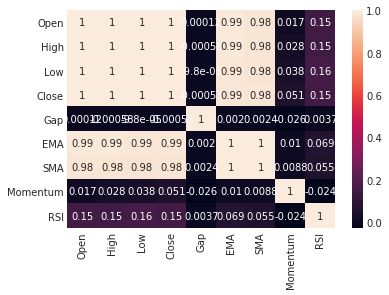

In [29]:
sns.heatmap(nasdaq.corr(), annot=True)

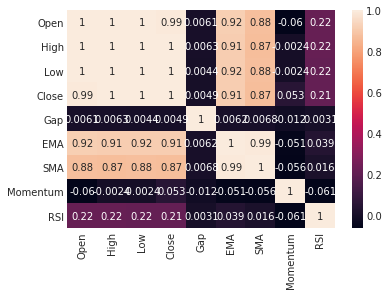

In [30]:
sns.heatmap(eurusd.corr(), annot=True)

# Close Price Prediction
Let's analyze how prediction problem may look like if we predict the Close price only.

In fact in the next notebook we will train a model with the Close price channel only as input. This gives an advantage because we can use the predicted value again as input.

In [31]:
def plot_all(data):
    plt.figure(figsize=(12,16))
    plt.subplot(311)
    plt.plot(data.iloc[:, data.columns.get_loc('Close')])
    plt.plot(data.iloc[:, data.columns.get_loc('EMA')], 'r')
    plt.plot(data.iloc[:, data.columns.get_loc('SMA')], 'g')
    plt.subplot(312)
    plt.plot(data.iloc[:, data.columns.get_loc('Momentum')])
    plt.subplot(313)
    plt.plot(data.iloc[:, data.columns.get_loc('RSI')])

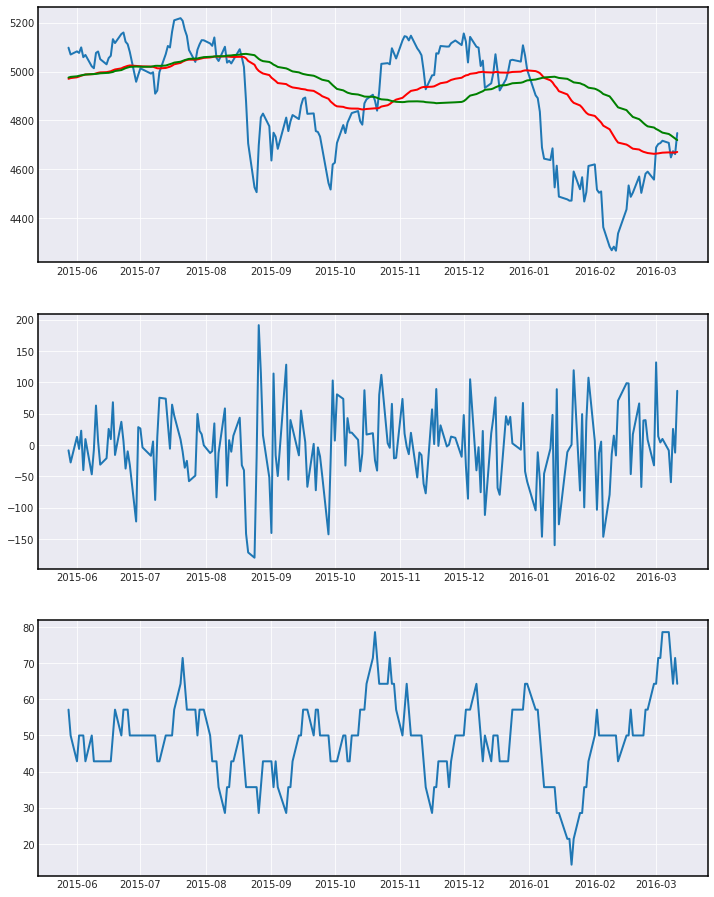

In [32]:
plot_all(nasdaq.iloc[100:300])

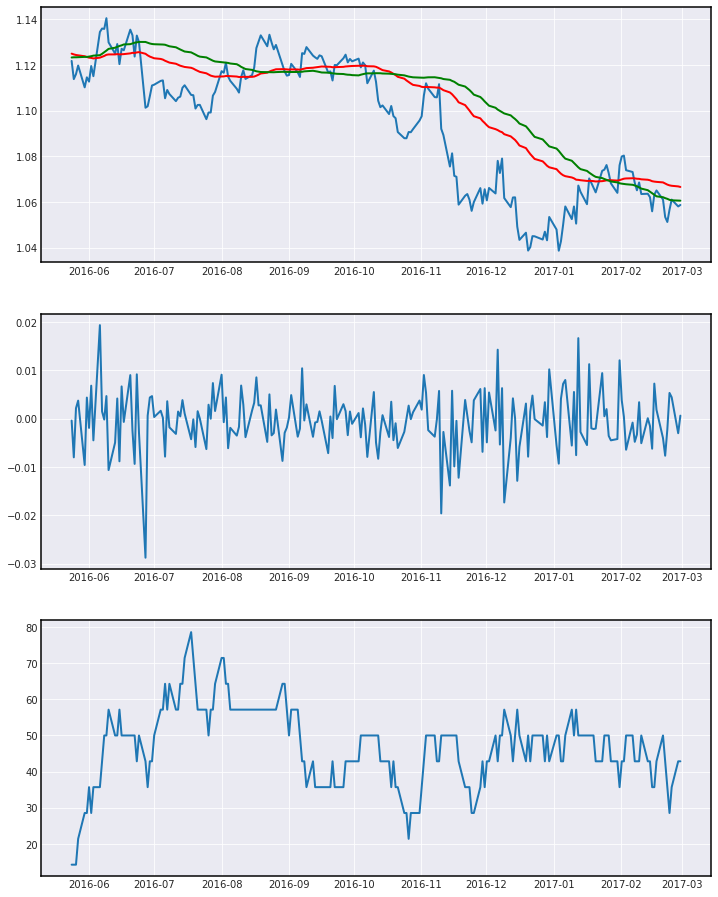

In [33]:
plot_all(eurusd.iloc[100:300])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93bb599d68>,
      dtype=object)

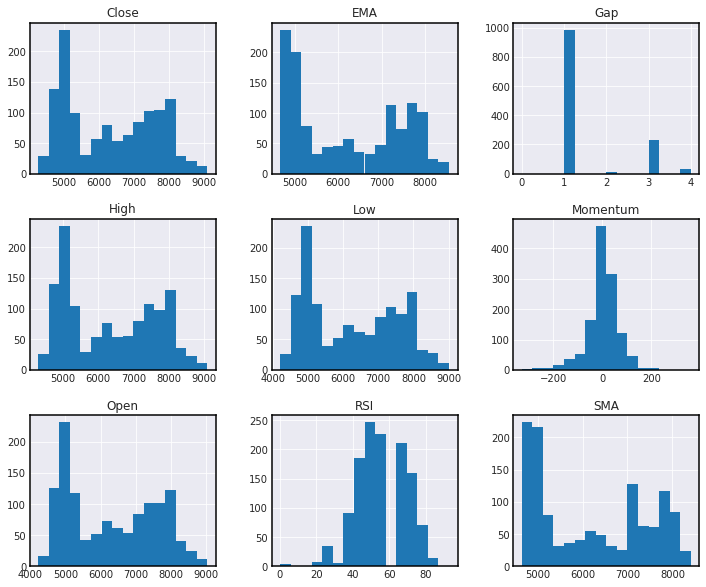

In [34]:
nasdaq.hist(figsize=(12,10), bins=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93b900c2b0>,
      dtype=object)

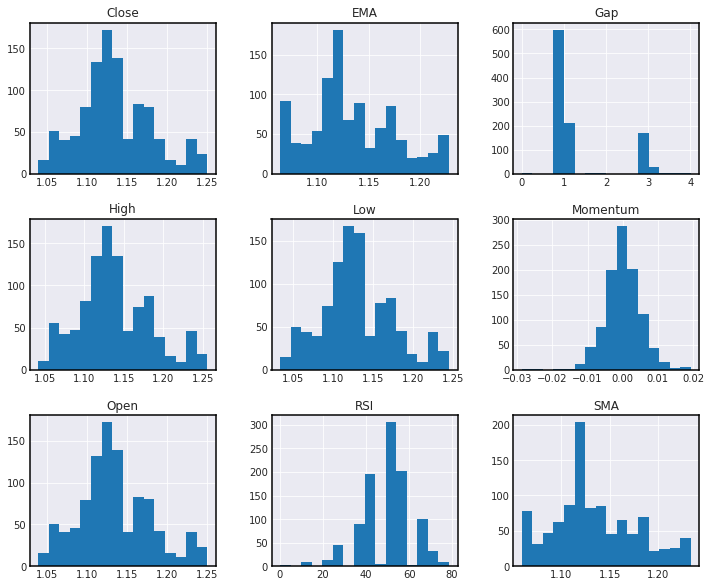

In [35]:
eurusd.hist(figsize=(12,10), bins=16)

# Export to CSV
Save our datasets to `train.csv` and `test.csv` files. I will cut first 10 rows because they have less accurate indicators' values, which was caused by missing data from the past.

Of course data is not shuffled, we want it in chronological order.

In [36]:
len(nasdaq), len(eurusd)

(1259, 1013)

In [37]:
0.8 * np.array([len(nasdaq), len(eurusd)])

array([1007.2,  810.4])

In [38]:
import os.path

In [41]:
nasdaq.iloc[10:1000].to_csv(os.path.join(data_dir, 'nasdaq_1d', 'train.csv'), header=False)
nasdaq.iloc[1000:].to_csv(os.path.join(data_dir, 'nasdaq_1d', 'test.csv'), header=False)

In [42]:
eurusd.iloc[10:810].to_csv(os.path.join(data_dir, 'eurusd_1d', 'train.csv'), header=False)
eurusd.iloc[810:].to_csv(os.path.join(data_dir, 'eurusd_1d', 'test.csv'), header=False)

# Shifted Close
Before we proceed to normalization let's add a column containing the ground truth: next Close price.

There is no need to export this column to CSV because Sliding Window approach can retrieve expected value in a better way.

In [82]:
@indicators.column_add_wrapper
def Ground(data):
    last = data.iloc[-1,data.columns.get_loc('Close')]
    data.loc[:,'Ground'] = np.append(data.iloc[1:,data.columns.get_loc('Close')].values, [last])
    return data

In [83]:
eurusd = Ground(eurusd)
nasdaq = Ground(nasdaq)

In [84]:
eurusd.head()

,Open,High,Low,Close,Gap,EMA,SMA,Momentum,RSI,Ground
Date,,,,,,,,,,
2016-01-04 17:03:00,1.08701,1.09464,1.07811,1.08310,0.0,1.083100,1.083100,0.00000,0.000000,1.07461
2016-01-05 17:03:00,1.08309,1.08388,1.07106,1.07461,1.0,1.082845,1.083100,-0.00849,0.000000,1.07807
2016-01-06 17:03:00,1.07458,1.07994,1.07185,1.07807,1.0,1.082702,1.078855,0.00346,0.000000,1.09307
2016-01-07 17:03:00,1.07805,1.09401,1.07710,1.09307,1.0,1.083013,1.078593,0.01500,50.000000,1.09184
2016-01-10 17:03:00,1.09298,1.09333,1.08030,1.09184,3.0,1.083278,1.082213,-0.00123,66.666667,1.08582


In [85]:
nasdaq.head()

,Open,High,Low,Close,Gap,EMA,SMA,Momentum,RSI,Ground
Date,,,,,,,,,,
2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,0.0,4726.810059,4726.810059,0.000000,0.000000,4652.569824
2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,3.0,4724.582852,4726.810059,-74.240235,0.000000,4592.740234
2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,1.0,4720.627573,4689.689942,-59.829590,0.000000,4650.470215
2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,1.0,4718.522853,4657.373372,57.729981,0.000000,4736.189941
2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,1.0,4719.052865,4655.647583,85.719726,33.333333,4704.069824


# Normalization
Market value can go as low as 0 and up to infinity, because we want our model to predict values in any range we need to work in a normalized space.
What is more, values distribution is very uneven, these transformations may help solve this problem.

I will showcase a few different normalization approaches:

Trainable:
- Batch normalization
- Convolution

Hyperparametrized:
- Moving Average

For this example transformation is being applied to every column. This is not always necessary, in fact some indicators are already normalized.
Such indicators are called osciallators (typically they range from 0 to 100), *RSI* is an oscillator.

## 1. Batch normalization
Example of batch normalization without trainable parameters (set in a way to not infuelence the data).

In [86]:
def batch_norm(data, eps=0, gamma=1, beta=0):
    import math
    std = data.std()
    mean = data.mean()
    for col in range(0, len(data.columns)):
        for i in range(0, len(data)):
            data.iloc[i, col] = (data.iloc[i, col] - mean[col]) * gamma / math.sqrt(std[col]**2 + eps) + beta
    return data

In [87]:
batch_eurusd = batch_norm(eurusd.iloc[100:200].copy())
batch_eurusd.head()

,Open,High,Low,Close,Gap,EMA,SMA,Momentum,RSI,Ground
Date,,,,,,,,,,
2016-05-23 20:14:00,0.423478,0.203631,0.494330,0.397522,-0.497491,1.527625,0.308374,-0.056324,-2.804508,-0.421832
2016-05-24 20:16:00,0.384052,0.036763,-0.083318,-0.431688,-0.498353,1.428786,0.326076,-1.380467,-2.804508,-0.194432
2016-05-25 20:17:00,-0.432462,-0.588992,-0.122178,-0.204123,-0.499216,1.352296,0.325476,0.389117,-2.804508,0.195990
2016-05-26 20:18:00,-0.201099,-0.069615,0.195004,0.186583,-0.499216,1.311384,0.335257,0.662298,-2.240220,-0.796679
2016-05-29 20:26:00,0.181739,-0.236483,-0.415203,-0.806806,1.991645,1.187077,0.360481,-1.655388,-1.675933,-0.340841


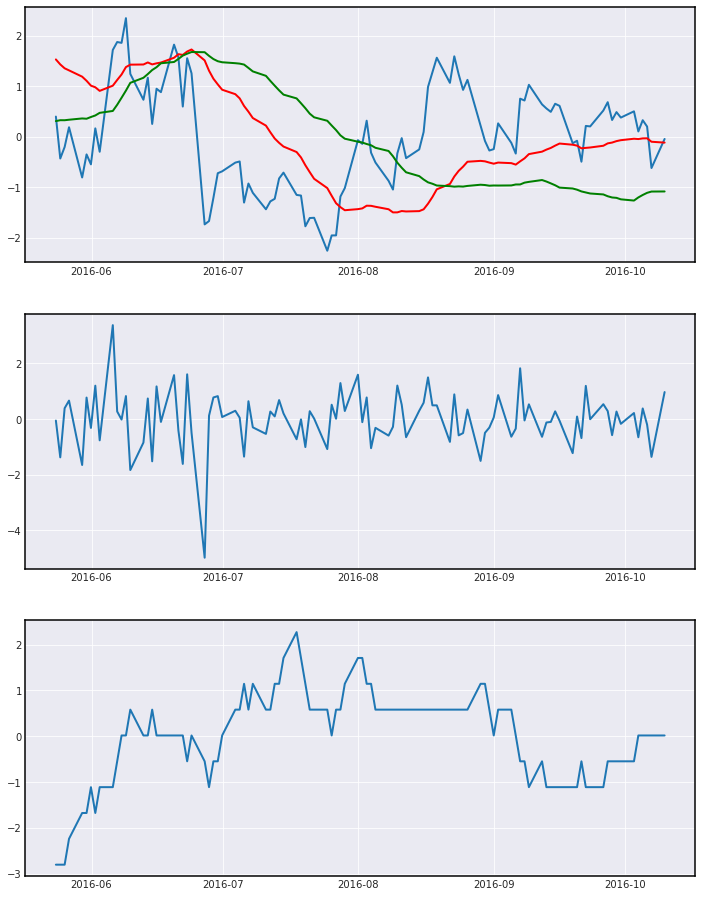

In [88]:
plot_all(batch_eurusd)

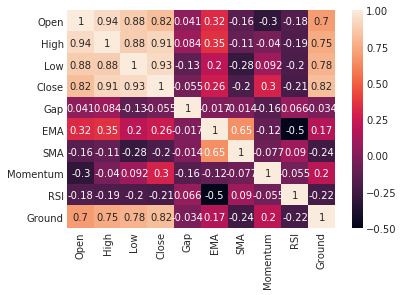

In [89]:
sns.heatmap(batch_eurusd.corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93b033e0b8>,
      dtype=object)

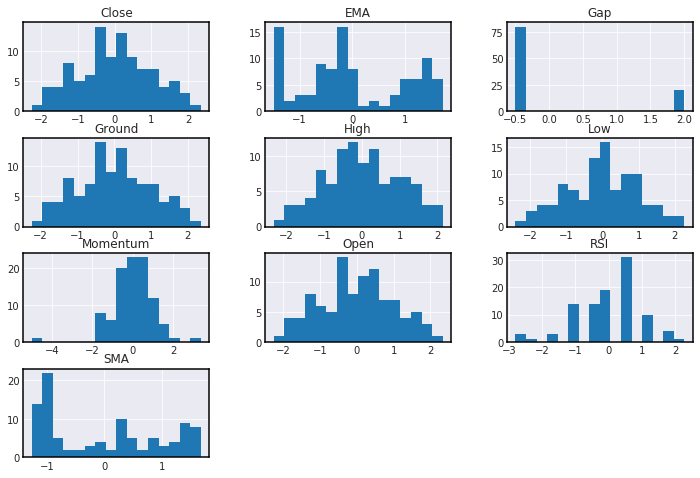

In [101]:
batch_eurusd.hist(figsize=(12,8), bins=16)

### Batch norm - summary
Batch normalization nicely centered all of our input channels around the value of 0. Still to solve the problem we have to use relatively small batches.

> Downside of this solution is that it works well only on relatively small batches.

## 2. Convolution example
Another solution is to apply convolution on input, either normalized first, or normalize convolved data.
If a sum of kernel coefficients equals 0, then such filter will normalize the input.

This is an example of how a trained filter may look like:

We apply batch norm after convolution.

The batch norm limitation to small size input is resolved.

> **Note:** The first 2 entries are removed! They are not transformed an should not be plotted (no padding was applied).

In [91]:
def conv(cf, data):
    filtered = data.copy()
    for col in range(0, len(data.columns)):
        for i in range(2, len(data)):
            filtered.iloc[i, col] = np.array(data.iloc[i-2:i+1, col]) @ cf
    return filtered

In [92]:
conv_filter = np.array([0.2, -1, 0.8])
conv_eurusd = batch_norm(conv(conv_filter, eurusd.iloc[100:].copy()))

# get rid of incorrect entries (we have not applied padding - data is lost)
conv_eurusd = conv_eurusd.iloc[2:]

conv_eurusd.head()

,Open,High,Low,Close,Gap,EMA,SMA,Momentum,RSI,Ground
Date,,,,,,,,,,
2016-05-25 20:17:00,-0.164575,-0.131509,-0.031179,0.017261,-0.002219,-0.049266,-0.046967,1.453658,-0.013565,0.002630
2016-05-26 20:18:00,0.017353,0.051920,0.001040,0.002430,-0.001746,-0.047721,-0.045829,-0.116779,1.362576,-0.207041
2016-05-29 20:26:00,0.001170,-0.089676,-0.146908,-0.206701,1.363301,-0.052477,-0.044852,-1.650499,1.018541,0.057179
2016-05-30 20:38:00,-0.207845,-0.114654,-0.029230,0.056838,-1.703120,-0.049208,-0.047477,2.080569,-0.357601,-0.092171
2016-05-31 20:40:00,0.060167,0.004886,-0.008018,-0.092127,0.333398,-0.050492,-0.043896,-1.175575,1.362576,0.065474


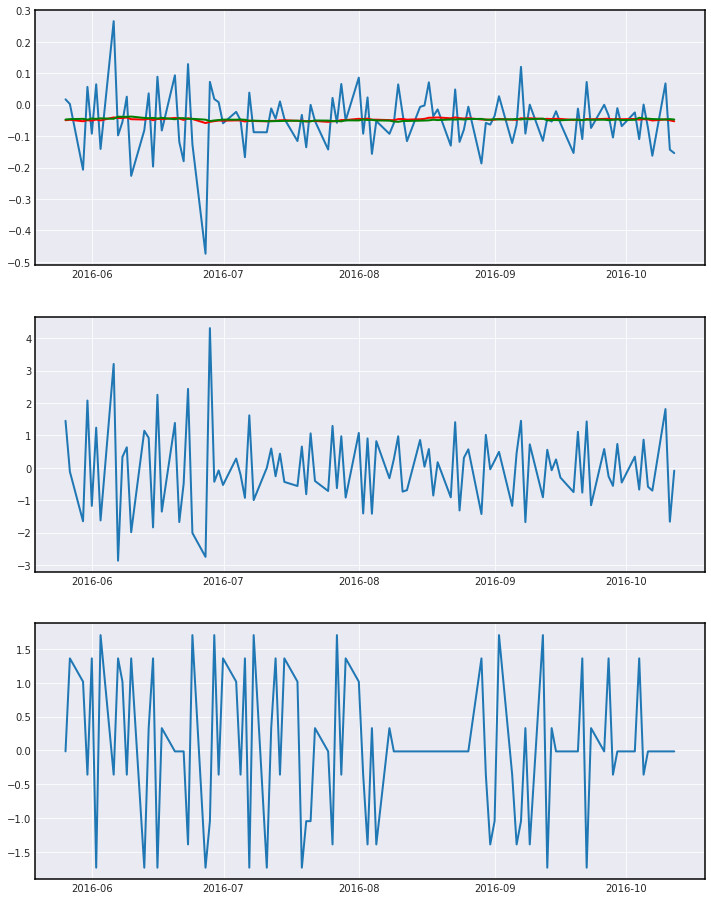

In [93]:
plot_all(conv_eurusd[:100])

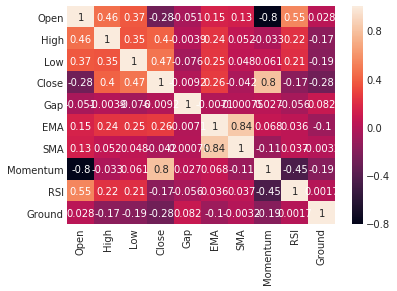

In [94]:
sns.heatmap(conv_eurusd.corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93b0b3b9e8>,
      dtype=object)

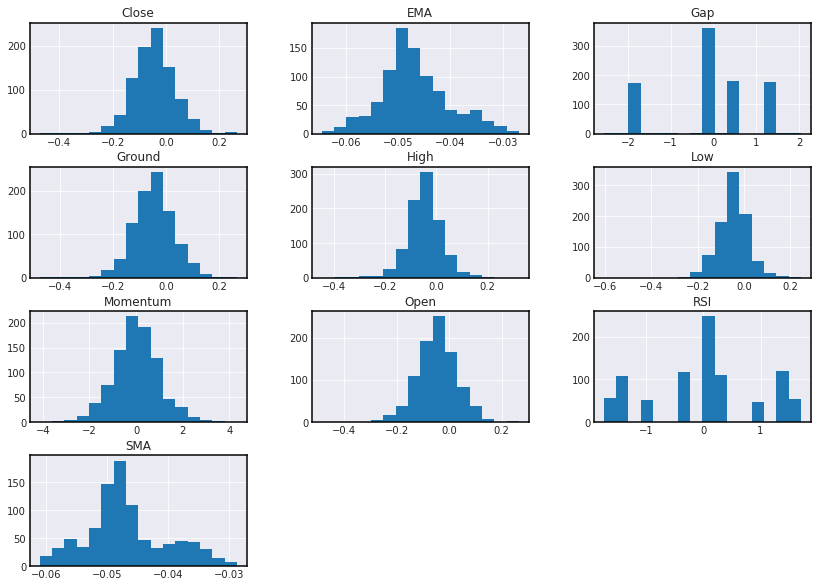

In [95]:
conv_eurusd.hist(figsize=(14,10), bins=16)

### Convolution - summary
Convolution looks very promising for this task. Histograms for the data indicate that data is well distributed, correlation matrix improved drastically - we have much more valueable data now. We have lost correlation with ground truth after applying such transformation, this might be an issue later. We want to detransform data back to expected value.

This is the solution we will implement in our model.

## 3. Moving Average
For reference I want to test a hyperparametrized approach as well. Hyperparameter is the Moving Average length parameter (N).

In [96]:
def ma_norm(data):
    for col in range(0, len(data.columns)):
        for i in range(0, len(data)):
            data.iloc[i, col] = data.iloc[i, col] - data.iloc[i, data.columns.get_loc('SMA')]
    return data

In [97]:
ma_eurusd = ma_norm(eurusd.iloc[100:800].copy())
ma_eurusd.head()

,Open,High,Low,Close,Gap,EMA,SMA,Momentum,RSI,Ground
Date,,,,,,,,,,
2016-05-23 20:14:00,-0.001199,0.000941,-0.004589,-0.001499,-0.121255,0.001687,0.0,-0.00037,14.285714,1.11386
2016-05-24 20:16:00,-0.001667,-0.000747,-0.010177,-0.009567,-0.122038,0.001264,0.0,-0.00798,14.285714,1.11605
2016-05-25 20:17:00,-0.009534,-0.006744,-0.010544,-0.007374,-0.122730,0.001008,0.0,0.00219,14.285714,1.11981
2016-05-26 20:18:00,-0.007353,-0.001813,-0.007573,-0.003663,-0.122779,0.000820,0.0,0.00376,21.428571,1.11025
2016-05-29 20:26:00,-0.003789,-0.003539,-0.013509,-0.013349,1.881957,0.000273,0.0,-0.00956,28.571429,1.11464


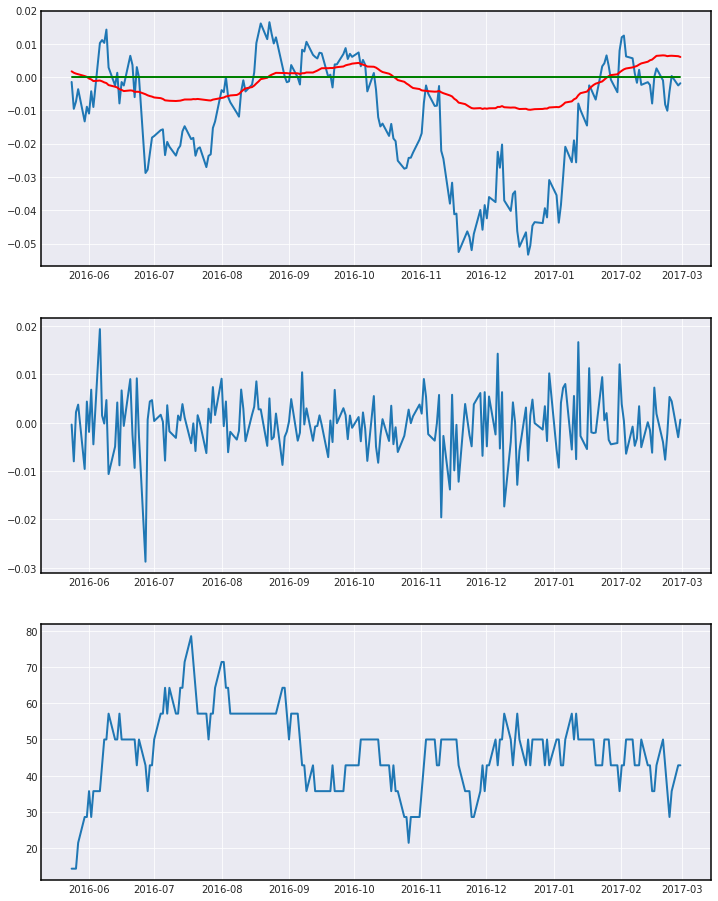

In [98]:
plot_all(ma_eurusd.iloc[:200])

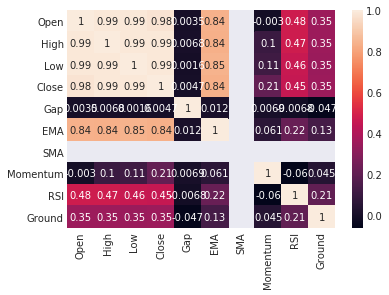

In [99]:
sns.heatmap(ma_eurusd.corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93b0781a90>,
      dtype=object)

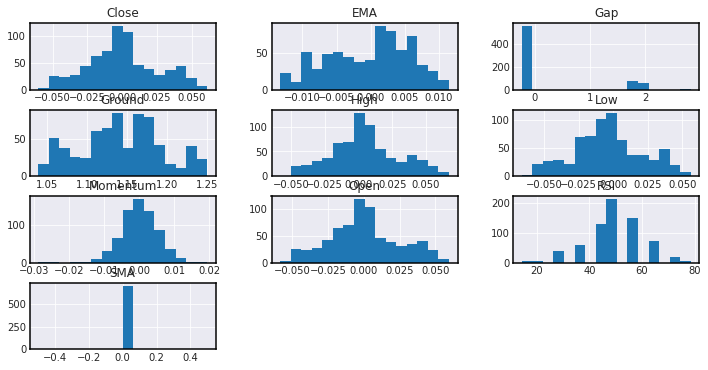

In [100]:
ma_eurusd.hist(figsize=(12,6), bins=16)

### MA - summary
This method still gives us pretty good results. In relation to its simplicity this could work very well, but I will not use it in the final model because of 3 reasons:
- discards SMA indicator (which can be fixed if we add another with different N parameter),
- harder to implement than batch normalization,
- it is not trainable like 2 other methods above but is hyperparametrized instead.

# Summary
We have loaded, explored, tested and exported our data for training.
This dataset contains full possible information, but it may not be necessary to use all of it.
Some columns (e.g. `Gap`) are imbalanced and probably will not provide much useful information.
I want to store it anyway, because it is easy to drop and difficult to add.

Now it is time to build a model, which will be explained and performed in the `Model.ipynb` notebook.